### Install Dependencies

In [89]:
!pip install pandas
!pip install fastparquet
!pip install spacy
!pip install matplotlib
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 3.4 MB/s eta 0:00:00a 0:00:01


In [60]:
# Spacy model
!python3 -m spacy download en_core_web_sm
# Load
import spacy
nlp = spacy.load('en_core_web_sm')

/Users/cody/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 41.7 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


### Imports and Data Loading

In [61]:
import pandas as pd

file_list = ["0000000", "0000001", "0000002"]
df = pd.read_parquet('data/000000.parquet', engine='fastparquet')


### Data Preprocessing

In [50]:
# Display options to show full prompts in "content"
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
# Cleaning: drop columns that won't be used for features
df_clean = df.drop(columns=['id', 'channel_id', 'image_id', 'timestamp', 'url', 'size'])
# Check for null values in "content"
print(f"Any null 'content' values? {df_clean['content'].isnull().values.any()}")

df_clean.sample(5)

Any null 'content' values? False


,content,height,width
947077,**<https://s.mj.run/p5YYBjmyWUs> girl Japan real happy** - <@958260413609439233> (fast),1024,1024
745533,"**Underwater temple of Poseidon, facade, game style --s 750 --q 2 --v 5** - Image #4 <@1074615309794807868>",1024,1024
449580,"**chinese dragon mandala, adult coloring book, patterns, no shading, empty space, white background, symetrical, black and white, thin lines, strong lines, wise eyes, surrounded in chinese style flames, show feet with claws** - Variations by <@1004484410755788830> (Open on website for full quality) (fast)",2048,2048
90298,"**Draw a 16-year-old girl wearing a Chinese qipao, which connects to the neck where the shoulder line appears, and wearing danghye, a traditional Chinese shoe. --niji 5** - <@1138366304022171648> (fast)",2048,2048
867672,"**mid-evil Knights helmet with ornate designs horns spikes, a gothic feel, and fantasy, mat black and gold, high resolution for mapping in 4K --v 5** - Image #1 <@792264590510522409>",1024,1024


### Cleaning prompt values for processing

In [51]:
df_v3 = df_clean.copy()
# Move user ids matching format <@1087096990002843650> anywhere in the string to a new column
df_v3['user_id'] = df_v3['content'].str.extract(r'<@(\d+)>')
# df_v3['content'] = df_v3['content'].str.replace(r'<@\d+>', '', regex=True) remove
# Actions such as "Upscaled", "Variations", "Remix" represent duplicate prompts and can be removed
# df_v3 = df_v3[~df_v3['content'].str.contains(r'Upscaled|Variations|Remix')]
# Only process actual prompt wrapped by "**" characters
df_v3['content'] = df_v3['content'].str.extract(r'\*\*(.*)\*\*')
# remove flags for now, including "--aspect", "-ar", "--v" and any characters that follow
df_v3['content'] = df_v3['content'].str.replace(r'(--aspect|-ar|--v|--s|--style).*', '', regex=True)
# Replace URLs with "<IMAGE_URL>" as a token
df_v3['content'] = df_v3['content'].str.replace(r'<https?:\/\/\S*', '<IMAGE_URL>', regex=True)
# preview changes
df_v3.sample(10)

,content,height,width,user_id
676836,dark shadow creature in a laser tag game,2048,2048,1103703414698954783
414116,poor girl in a buss looking through the window of passing by scenery,1024,1024,1001892110934487080
159272,"Scottish Fold cat has short ears, white body, mafia, standing in the city.",2048,2048,1134208426210246698
981221,bitcoin bottom of well,1024,1024,1078095904818606161
251346,Please create a hyper realistic photograph showing a modern building reception with a smiling young woman giving her identification document to an guard who is behind a counter looking at his monitor,1024,1024,1128326796912365651
419868,buisness hand shaking illustration with light color -,1632,2912,631940740733206528
839062,"Historic Photography, 1850’s, portrait young French farm man, daguerreotype, Alphonse Giroux et Cie camera, depth of field, all is sharp focus: face, hair, clothes, no contrast, soft shadows, don’t show hands –ar 4:3 –v5",2048,2048,1091877557374287963
705389,"2d outline simple vector monochrome coloring page cute little witcher, medieval town background -",2688,1792,253604855082385409
216770,"<IMAGE_URL> Full body image of a woman in a very colorful Indian traditional gown with the likeness of goddess Sita, running away, facing forward in a photorealistic image in the deep Indian forest. Use a Nikon D850 DSLR 4k camera with a 200mm lens and F 1.2 aperture setting to create a shallow depth of field and blur the background. The woman should be in a grassy savanna, with a warm, orange glow from the setting sun to create a dramatic effect.",2048,2048,1115617695166107761
553787,"brewing coffee workshop with friends, vibrant cafe, wooden tones, greenery plants. art style of monsters inc.",2048,2048,363829959514390569


### Exploratory Data Analysis

Starting off using Spacy to identify tokens, counts

In [150]:
df_v4 = df_v3.copy()
# Explore distributions on a sample of 10000 rows
df_v4 = df_v4.sample(1000)
df_v4 = df_v4.sample(1000000)
# 1 min for 10,000 rows

# Function to count tokens and nouns in a text
def count_tokens_and_nouns(text):
    doc = nlp(text)
    tokens = doc
    token_count = len(tokens)
    nouns = [token.text for token in doc if token.pos_ == 'NOUN']
    noun_count = len(nouns)
    entities = [ent.text for ent in doc.ents if ent.label_ not in ['CARDINAL', 'QUANTITY']]
    entity_count = len(entities)
    entity_types = [ent.label_ for ent in doc.ents if ent.label_ not in ['CARDINAL', 'QUANTITY']]
    return token_count, tokens, noun_count, nouns, entity_count, entities, entity_types

# Apply the function to the "content" column of df_v3
df_v4['token_count'], df_v4['tokens'], df_v4['noun_count'], df_v4['nouns'], df_v4['entity_count'], df_v4['entities'], df_v4['entity_types'] = zip(*df_v4['content'].apply(count_tokens_and_nouns))

# Print the resulting dataframe
df_v4.sample(10)

,content,height,width,user_id,token_count,tokens,noun_count,nouns,entity_count,entities,entity_types
641389,sticker for tow hajabi girls Graduation,2048,2048,1074706502687928441,6,"(sticker, for, tow, hajabi, girls, Graduation)",2,"[hajabi, girls]",1,[Graduation],[ORG]
679436,serait-il possible de créer un magnifique mur végétal dans la boutique de luxe pour ajouter un mur végétal dans le fond du magasin,2048,2048,819269142606774284,25,"(serait, -, il, possible, de, créer, un, magnifique, mur, végétal, dans, la, boutique, de, luxe, pour, ajouter, un, mur, végétal, dans, le, fond, du, magasin)",1,[magasin],5,"[un, dans la boutique de luxe pour, un, végétal, dans]","[ORG, ORG, ORG, ORG, NORP]"
868350,"Birds-eye view of an Orc with a slightly green translucid skin, intense light inside his chest, holding a gun-axe in hand, wearing robe and wood futuristic armor, dirty",2048,2048,333512691090194454,36,"(Birds, -, eye, view, of, an, Orc, with, a, slightly, green, translucid, skin, ,, intense, light, inside, his, chest, ,, holding, a, gun, -, axe, in, hand, ,, wearing, robe, and, wood, futuristic, armor, ,, dirty)",13,"[Birds, eye, view, translucid, skin, light, chest, gun, axe, hand, robe, wood, armor]",0,[],[]
478092,"a person shouting yes, white background",2048,2048,794580651876679693,7,"(a, person, shouting, yes, ,, white, background)",2,"[person, background]",0,[],[]
757193,president obama surfing inside a curl wave --q 2 -,1344,896,1057758687986462850,10,"(president, obama, surfing, inside, a, curl, wave, --q, 2, -)",2,"[curl, wave]",0,[],[]
874942,"an birds-eye view of high density amazon forest, robert frank photograph style, 500m, foggy weather, full of tress, black and white, low contrast, intricate details, 8k, beautiful -",1632,2912,1092816778893213837,40,"(an, birds, -, eye, view, of, high, density, amazon, forest, ,, robert, frank, photograph, style, ,, 500, m, ,, foggy, weather, ,, full, of, tress, ,, black, and, white, ,, low, contrast, ,, intricate, details, ,, 8k, ,, beautiful, -)",9,"[birds, eye, view, density, style, weather, tress, contrast, details]",1,[robert frank],[PERSON]
6850,<IMAGE_URL> husband and wife happy wearing the exact necklace from the picture outside,2048,2048,677965637204705334,15,"(<, IMAGE_URL, >, husband, and, wife, happy, wearing, the, exact, necklace, from, the, picture, outside)",3,"[wife, necklace, picture]",0,[],[]
432991,"strange and scary surreal 8k, Hyper realistic, UHD",1632,2912,1046334055936962621,10,"(strange, and, scary, surreal, 8k, ,, Hyper, realistic, ,, UHD)",0,[],2,"[Hyper, UHD]","[GPE, ORG]"
924962,"low poly icons in stone, metal and food",1024,1024,1089480360385060914,9,"(low, poly, icons, in, stone, ,, metal, and, food)",4,"[icons, stone, metal, food]",0,[],[]
710550,A large menacing Bear wearing a lebron james jersey,1024,1024,1059612313495289906,9,"(A, large, menacing, Bear, wearing, a, lebron, james, jersey)",0,[],2,"[Bear, james jersey]","[ORG, PERSON]"


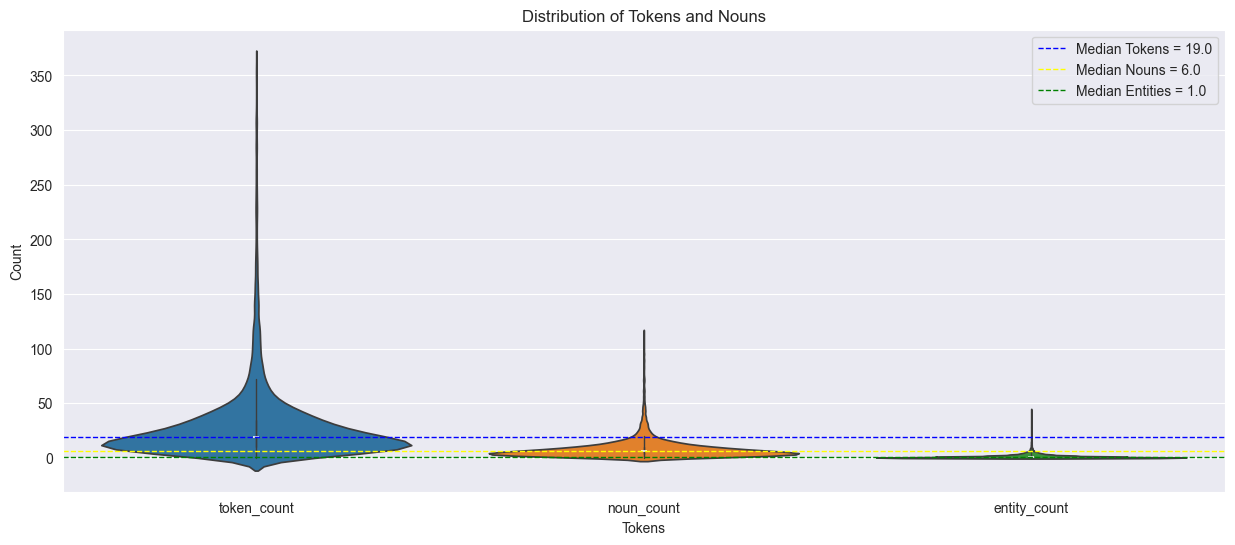

In [152]:
# Plot the distribution of tokens and nouns as violin plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(15, 6))
sns.violinplot(data=df_v4[['token_count', 'noun_count', 'entity_count']], ax=ax)
ax.set_title('Distribution of Tokens and Nouns')
ax.set_xlabel('Tokens')
ax.set_ylabel('Count')
# Include two horizontal lines to indicate median nouns and median tokens, with labels
ax.axhline(df_v4['token_count'].median(), ls='--', color='blue', label=f'Median Tokens = {df_v4["token_count"].median()}')
ax.axhline(df_v4['noun_count'].median(), ls='--', color='yellow', label=f'Median Nouns = {df_v4["noun_count"].median()}')
ax.axhline(df_v4['entity_count'].median(), ls='--', color='green', label=f'Median Entities = {df_v4["entity_count"].median()}')
# adjust line stroke to be thinner
for l in ax.lines:
    l.set_linewidth(1)
plt.legend()
plt.show()


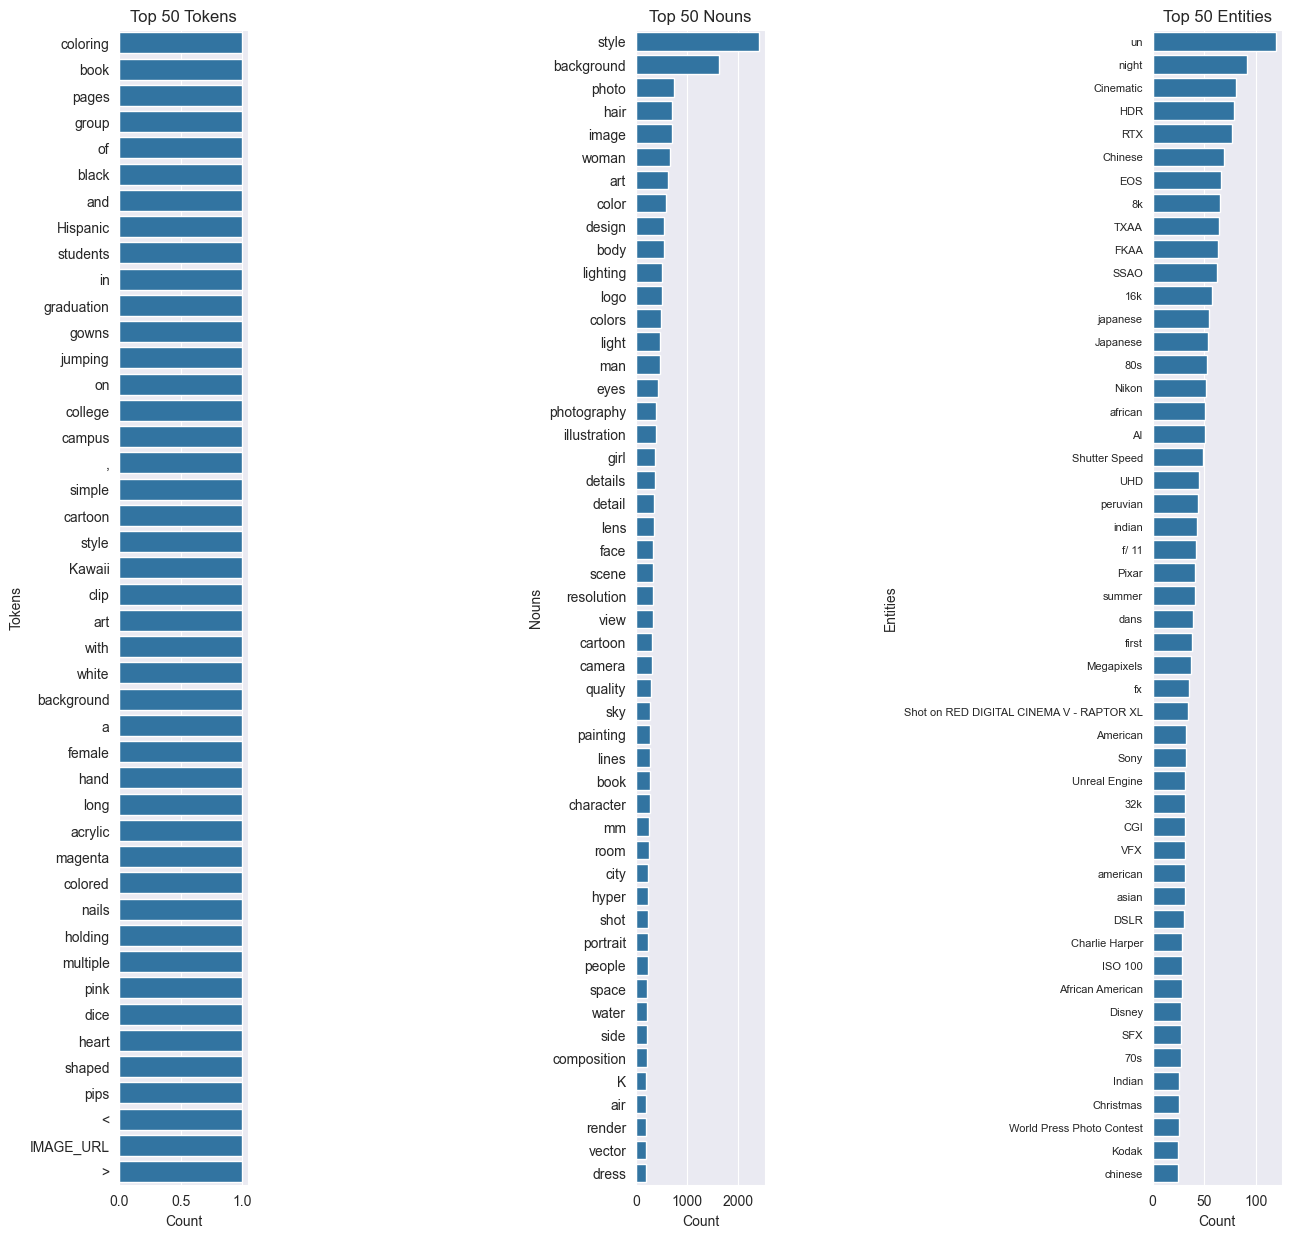

In [175]:
# plot clusters of common entities
from collections import Counter
from itertools import chain

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
# add space between subplots
fig.subplots_adjust(wspace=3.0)

def plot_top(df, column, fix, ax, top=100):
    values = Counter(chain.from_iterable(df_v4[column]))
    top_values = values.most_common(top)
    # Plot!
    sns.barplot(y=[e[0] for e in top_values], x=[e[1] for e in top_values], ax=ax)
    ax.set_title(f'Top {top} {column.capitalize()}')
    ax.set_xlabel('Count')
    ax.set_ylabel(column.capitalize())

# plot on 4 subplots
plot_top(df_v4, 'tokens', fig, ax[0], top=50)
plot_top(df_v4, 'nouns', fig, ax[1], top=50)
plot_top(df_v4, 'entities', fig, ax[2], top=50)

plt.yticks(fontsize=8)
plt.show()